## Train dataset on MNIST :(

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn

import torchvision.transforms as transforms

import numpy as np

import torchvision
import torch

In [3]:
from tqdm import tqdm

In [4]:
device = 'cuda'

In [5]:
# net = torchvision.models.resnet18(pretrained=True)
net = torchvision.models.resnet50(pretrained=True)

# Replace 1st layer to use it on grayscale images
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
net = net.to(device)

In [6]:
# net.load_state_dict(torch.load("./resnet18_mnist.pth"))
net.load_state_dict(torch.load("./resnet50_mnist.pth"))

<All keys matched successfully>

## Extract features from picture

In [7]:
import cv2
import matplotlib.pyplot as plt


from data_preprocessing import crop_and_warp, find_corners_of_largest_polygon, pre_process_image, remove_stuff


In [8]:
img = cv2.imread("./sudoku_real_1.jpeg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

pre_preocessed = pre_process_image(gray)

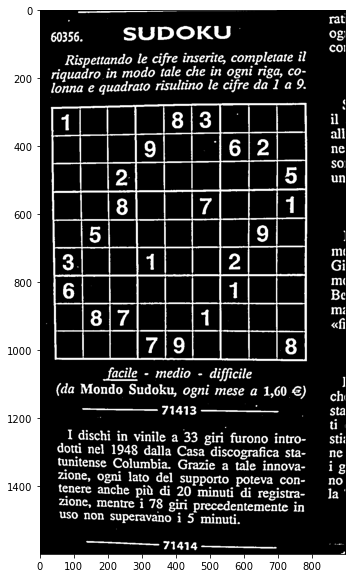

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(pre_preocessed, cmap='gray')



### Isolate area of the grid

In [10]:
corners = find_corners_of_largest_polygon(pre_preocessed)

In [11]:
cropped = crop_and_warp(pre_preocessed, corners)

## Solve sudoku!

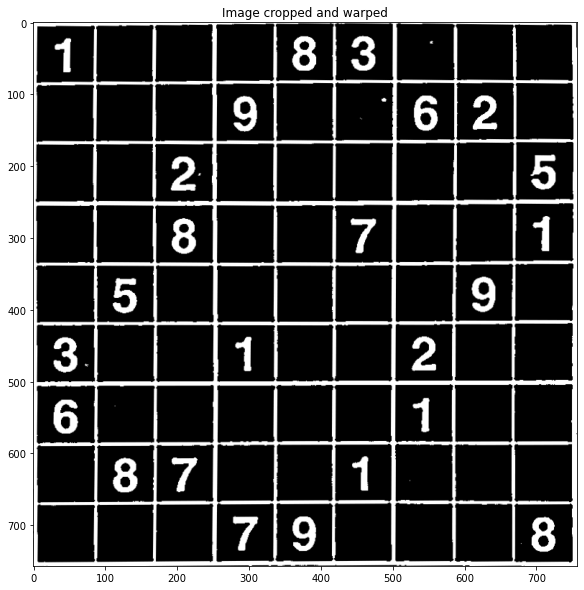

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(cropped, cmap='gray')
plt.title("Image cropped and warped");

In [13]:
_, cropped_t = cv2.threshold(cropped,127,255,cv2.THRESH_TOZERO)

In [14]:
cropped = cropped_t

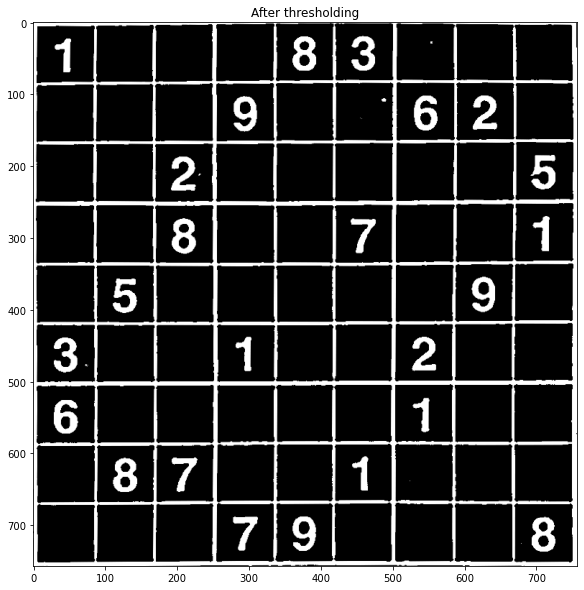

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(cropped_t, cmap='gray')
plt.title("After thresholding");

In [16]:
def slice_grid(grid, i, j, W):
    """
    Assuming grid is an array representing the image, return a single square
    based on its coordinates (which start from 0). 
    """
    
    i_start = i * W
    i_end = i_start + W
    
    j_start = j * W
    j_end = j_start + W
        
    aa = grid[i_start:i_end, j_start:j_end]
    return aa
    

In [17]:
w, h = cropped.shape

W = w//9


In [18]:
# # aa = slice_grid(thresholded, 1, 4, W) # a 6
# aa = slice_grid(thresholded, 4, 6, W) # a 6
# # aa = slice_grid(thresholded, 3, 4, W) # a 3
# # aa = slice_grid(thresholded, 0, 1, W) # an empty square
# # aa = slice_grid(thresholded, 0, 0, W) # a 1
# plt.figure(figsize=(10,10))
# plt.imshow(aa, cmap='gray')

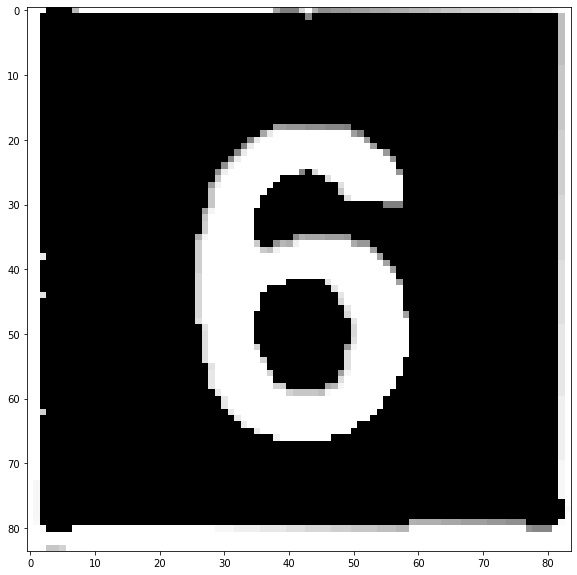

In [19]:
aa = slice_grid(cropped, 1, 6, W)
plt.figure(figsize=(10,10))
plt.imshow(aa, cmap='gray')

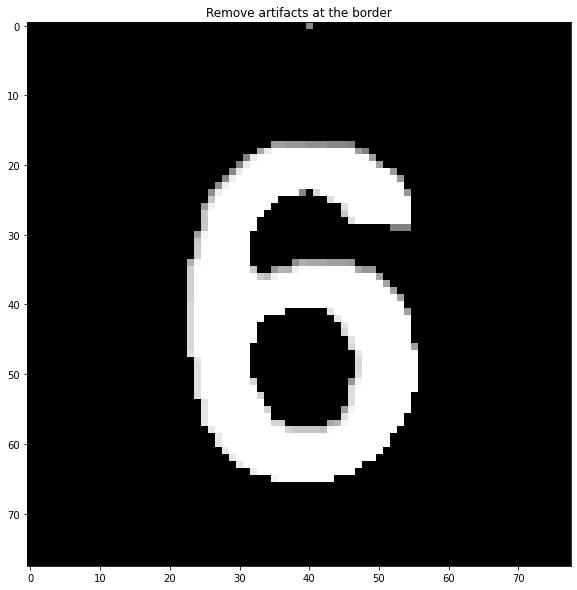

In [20]:
out = remove_stuff(aa)

plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gray')
plt.title("Remove artifacts at the border");

In [21]:
resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)

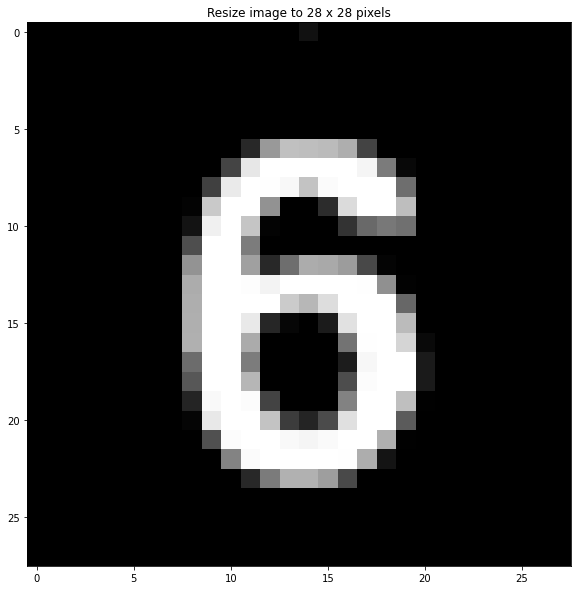

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(resized, cmap='gray')
plt.title("Resize image to 28 x 28 pixels");

In [23]:
from sudoku_solver import find_empty_grid, print_board, solve_array

In [24]:
def smart_classify(resized, net, threshold=75, device='cuda', conf_threshold=0.9, debug=False):
    """
    First determined whether the cell is empty or not, checking the number of pixels different from zero.
    Then use a neural network to classify digits.
    """
    
    # Identify blank cells
    if (resized != resized.min()).sum() < threshold:
        return " "
    
    net.eval()
    iii = torch.Tensor(resized).to(device).unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad():
        out = net(iii)
        sm = torch.nn.functional.softmax(out, dim=1)
        
    if debug:
        print(f"Logits: {out}")
        print(f"Softmax: {sm}")
        
    _, P = torch.max(out, 1)
    
    digit = P.item()
    conf = sm.squeeze()[digit].item()
    
    if debug:
        print(f"Predicted digit: {digit} with confidence {conf:.3f}")
    
    if digit != 0 and conf>conf_threshold:
        return str(digit)
    else:
        return " "    

In [25]:
smart_classify(resized/255, net, debug=True)

Logits: tensor([[-0.2507, -2.0413, -2.9794, -2.3444, -2.4834,  5.3105,  3.8151, -2.5793,
          0.3025, -0.8157]], device='cuda:0')
Softmax: tensor([[3.1024e-03, 5.1768e-04, 2.0262e-04, 3.8232e-04, 3.3271e-04, 8.0709e-01,
         1.8091e-01, 3.0229e-04, 5.3948e-03, 1.7633e-03]], device='cuda:0')
Predicted digit: 5 with confidence 0.807


' '

In [26]:
w, h = cropped.shape

W = w//9

In [27]:
digits = list()


for i in range(9):
    i_start = i * W
    i_end = i_start + W
    
    for j in range(9):
        
        j_start = j * W
        j_end = j_start + W
        
        # Slice a cell from the original image
        aa = slice_grid(cropped_t, i, j, W)
        
        bb = aa.astype(float)/255
#         bb = 1 - bb
        
        # Isolate digit from rest of the cell
        out = remove_stuff(bb)
        
        # Resize to 28x28
        resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)
        digits.append(smart_classify(resized, net, conf_threshold=0.9))


In [28]:
def convert(d):
    if d == ' ':
        return 0
    else:
        return int(d)

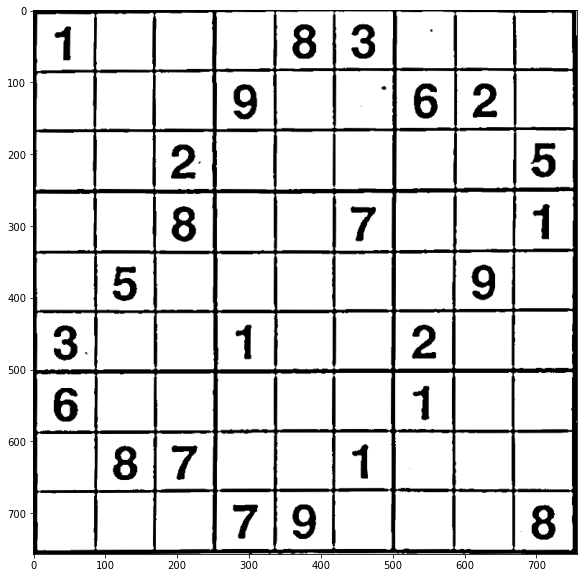

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(255-cropped, cmap='gray')

In [30]:
digits_int = np.array([convert(d) for d in digits])

digits_int = digits_int.reshape((9, 9))

In [31]:
digits_list = [list(ll) for ll in list(digits_int)]

In [32]:
print_board(digits_list)

. . .  | . 8 3  | . . .
. . .  | 9 . .  | 5 2 .
. . 2  | . . .  | . . 5
- - - - - - - - - - - - - 
. . 8  | . . 7  | . . 1
. 5 .  | . . .  | . 9 .
5 . .  | . 1 .  | 2 . .
- - - - - - - - - - - - - 
. . .  | . 1 .  | 1 . .
. 8 7  | . . 1  | . . .
. . .  | 7 . .  | . . 8


In [33]:

digits_list = list(digits_list)

solve_array(digits_list)

False

In [34]:
print_board(digits_list)

. . .  | . 8 3  | . . .
. . .  | 9 . .  | 5 2 .
. . 2  | . . .  | . . 5
- - - - - - - - - - - - - 
. . 8  | . . 7  | . . 1
. 5 .  | . . .  | . 9 .
5 . .  | . 1 .  | 2 . .
- - - - - - - - - - - - - 
. . .  | . 1 .  | 1 . .
. 8 7  | . . 1  | . . .
. . .  | 7 . .  | . . 8
